In [49]:
import numpy as np 
import pandas as pd 

def sigmoid(w, X):
	# w.T dot X
	x = w.reshape(1, -1).dot(X.T).reshape(-1, 1)
	sig = x.copy()
	for i, el in enumerate(x):
		if el < 0:
			sig[i] = np.exp(el)/(1 + np.exp(el))
		else:
			sig[i] = 1/(1 + np.exp(-el))
	return sig


# first derivative
def gradient(w, alpha,  X, t):
  N = len(t)
  y = sigmoid(w, X)
  t_reshaped = t.values.reshape(-1, 1)
  return X.T.dot(y - t_reshaped) + (alpha * w).reshape(-1, 1)

# second derivative
def hessian(w, H_0, X, t):
  N = len(t)
  y = sigmoid(w, X)

  h = (y * (1 - y)).flatten()

  R = np.diag(h)
  return X.T.dot(R).dot(X) + H_0

def newton_raphson(w, X, t, max_iter=100, epsilon=1e-3, learning_rate=0.1):
  converged = 1
  # iteration count
  num_iter = 1
  alpha = 1/2

  # alpha^-1 * I
  H_0 = np.linalg.inv(np.identity(X.shape[1]) * alpha)

  w_t = w.copy() # w_curr
  while ((converged > epsilon) & (num_iter < max_iter)):
    g_t = gradient(w_t, alpha, X, t)
    H_t = np.linalg.inv(hessian(w_t, H_0, X, t))

    d_t = H_t.dot(g_t)

    w_new = w_t - learning_rate * d_t.flatten()
    num_iter += 1
    converged = np.linalg.norm(w_new - w_t)

    w_t = w_new 

  return w_t, num_iter


In [ ]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
import time
# start the program
df = pd.read_csv('dota2Train.csv', header=None)
test_set = pd.read_csv('dota2Test.csv', header=None)

# replace -1 for 0 for "lose"
df[0] = [0 if x < 0 else 1 for x in df[0]]
test_set[0] = [0 if x < 0 else 1 for x in test_set[0]]

# dropping the team_id column
df.drop(1, axis = 1, inplace=True)
test_set.drop(1, axis = 1, inplace=True)

y_test = test_set[0]
x_test = test_set.iloc[:, 1:]

N = [500, 750, 1000, 2500, 5000, 7500, 10000]
train_acc_list = []
test_acc_list = []
train_time_list = []
num_iter_list = []
train_logloss_list = []
test_logloss_list = []
sklearn_train_acc = []
sklearn_test_acc = []

for n in N:
  # get a sample of dataset -- not crash the program
  df_small = df.sample(n, random_state = 123)
  y_train = df_small[0]
  x_train = df_small.iloc[:, 1:]

  # reduce dimension
  x_train = PCA(n_components = 50, random_state=0).fit_transform(x_train)
  x_test = PCA(n_components = 50, random_state=0).fit_transform(x_test)

  # initialize weights
  w_init = np.random.rand(x_train.shape[1])

  # calculate w_MAP
  start_time = time.time()
  set_weights, total_iter = newton_raphson(w_init, x_train, y_train)
  end_time = time.time()
  num_iter_list.append(total_iter)
  train_time_list.append(end_time - start_time)

  # predict
  predict_proba = set_weights.reshape(-1, 1).T.dot(x_train.T)
  train_label = [1 if x > 0.5 else 0 for x in predict_proba[0]]
  train_accuracy = np.mean(y_train == train_label)
  train_acc_list.append(train_accuracy)
  train_logloss_list.append(log_loss(y_train, predict_proba[0]))

  predict_proba_test = set_weights.reshape(-1, 1).T.dot(x_test.T)
  test_label = [1 if x > 0.5 else 0 for x in predict_proba_test[0]]
  test_accuracy = np.mean(y_test == test_label)
  test_acc_list.append(test_accuracy)
  test_logloss_list.append(log_loss(y_test, predict_proba_test[0]))

  # compare with sklearn
  lr = LogisticRegression(penalty='none', solver='newton-cg')
  lr.fit(x_train, y_train)
  sklearn_coefs = lr.coef_
  sklearn_score_train = lr.score(x_train, y_train)
  sklearn_train_acc.append(sklearn_score_train)
  sklearn_score_test = lr.score(x_test, y_test)
  sklearn_test_acc.append(sklearn_score_test)

  # difference in weights
  print("Difference in two sets of weights: ", np.linalg.norm(set_weights - sklearn_coefs))

Difference in two sets of weights:  0.17646004400430992
Difference in two sets of weights:  0.09029012239521662
Difference in two sets of weights:  0.05825749659622854
Difference in two sets of weights:  0.022033421424475855
Difference in two sets of weights:  0.016702820105300595
Difference in two sets of weights:  0.016116646475681347
Difference in two sets of weights:  0.013680006657082118


In [ ]:
# ROC_AUC score for the N = 10000 model
df_small = df.sample(10000, random_state = 123)
y_train = df_small[0]
x_train = df_small.iloc[:, 1:]

# reduce dimension
x_train = PCA(n_components = 50, random_state=0).fit_transform(x_train)
x_test = PCA(n_components = 50, random_state=0).fit_transform(x_test)

# initialize weights
w_init = np.random.rand(x_train.shape[1])
set_weights, _ = newton_raphson(w_init, x_train, y_train)

# predict
predict_proba = set_weights.reshape(-1, 1).T.dot(x_train.T)
predict_proba_test = set_weights.reshape(-1, 1).T.dot(x_test.T)

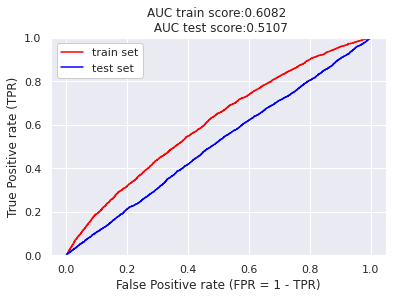

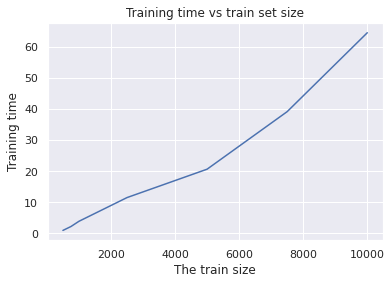

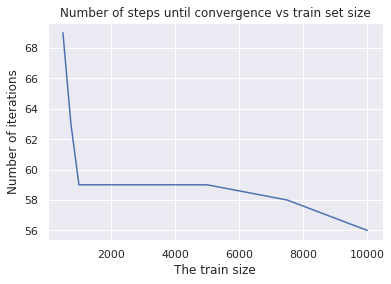

In [ ]:
# roc curve for train and test
fpr, tpr, thr = roc_curve(y_train, predict_proba[0])
fpr_test, tpr_test, thr_test = roc_curve(y_test, predict_proba_test[0])

fig, ax = plt.subplots(sharey=True)
ax.plot(fpr, tpr, color='red', label = 'train set')
ax.plot(fpr_test, tpr_test, color='blue', label = 'test set')
plt.xlabel('False Positive rate (FPR = 1 - TPR)');
plt.ylabel('True Positive rate (TPR)');
plt.ylim([0, 1]);
plt.title("AUC train score:{} \n AUC test score:{}".format(
    round(roc_auc_score(y_train, predict_proba[0]),4), 
    round(roc_auc_score(y_test, predict_proba_test[0]),4)))
plt.legend(frameon=True, framealpha=1,facecolor='white')
plt.show()

# runtime
plt.plot(N, train_time_list)
plt.xlabel("The train size")
plt.ylabel("Training time")
plt.title("Training time vs train set size")
plt.show()

# num_iter
plt.plot(N, num_iter_list)
plt.xlabel("The train size")
plt.ylabel("Number of iterations")
plt.title("Number of steps until convergence vs train set size")
plt.show()

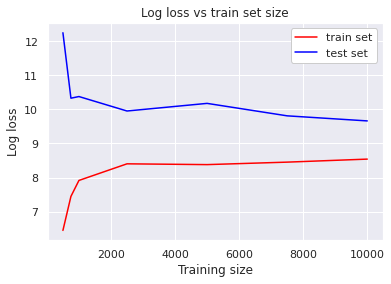

In [ ]:
fig, ax = plt.subplots(sharey=True)
ax.plot(N, train_logloss_list, color='red', label = 'train set')
ax.plot(N, test_logloss_list, color='blue', label = 'test set')
plt.xlabel('Training size');
plt.ylabel('Log loss');
plt.title("Log loss vs train set size")
plt.legend(frameon=True, framealpha=1,facecolor='white')
plt.show()

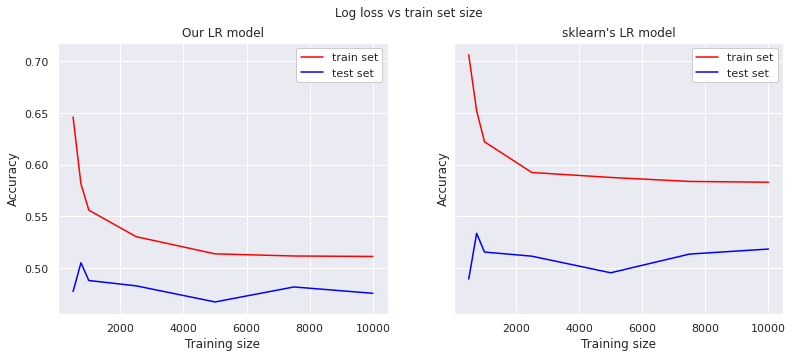

In [51]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(13, 5))
ax[0].plot(N, train_acc_list, color='red', label = 'train set')
ax[0].plot(N, test_acc_list, color='blue', label = 'test set')

ax[1].plot(N, sklearn_train_acc, color='red', label = 'train set')
ax[1].plot(N, sklearn_test_acc, color='blue', label = 'test set')

ax[0].set_xlabel('Training size');
ax[1].set_xlabel('Training size');

ax[0].set_ylabel('Accuracy');
ax[1].set_ylabel('Accuracy');

fig.suptitle("Log loss vs train set size")
ax[0].legend(frameon=True, framealpha=1,facecolor='white')
ax[1].legend(frameon=True, framealpha=1,facecolor='white')

ax[0].set_title('Our LR model');
ax[1].set_title("sklearn's LR model");
plt.show()